In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = random.randint(0, 2)
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 25  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



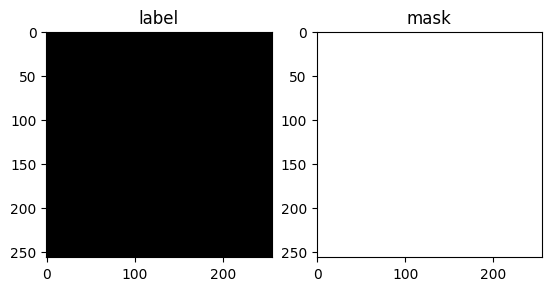

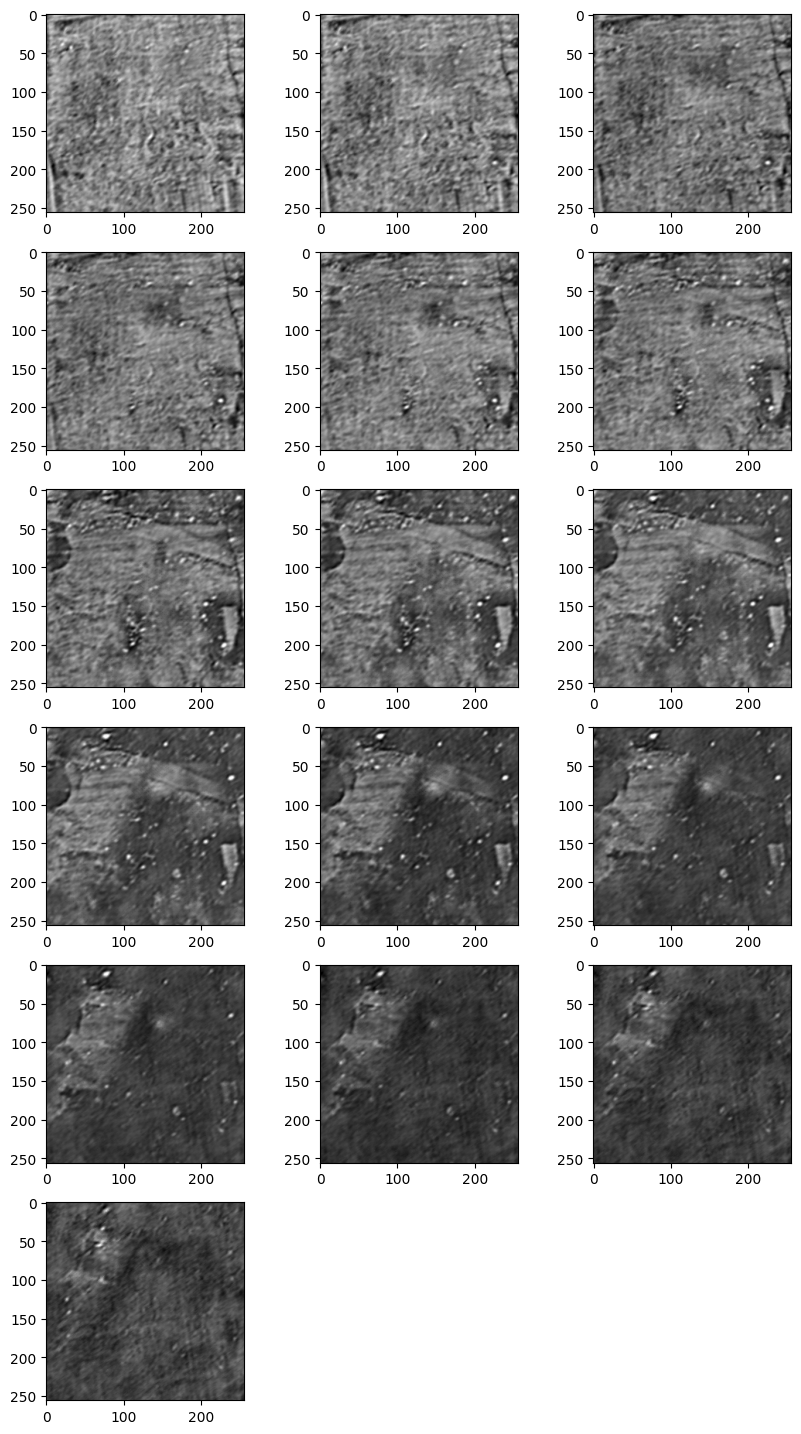

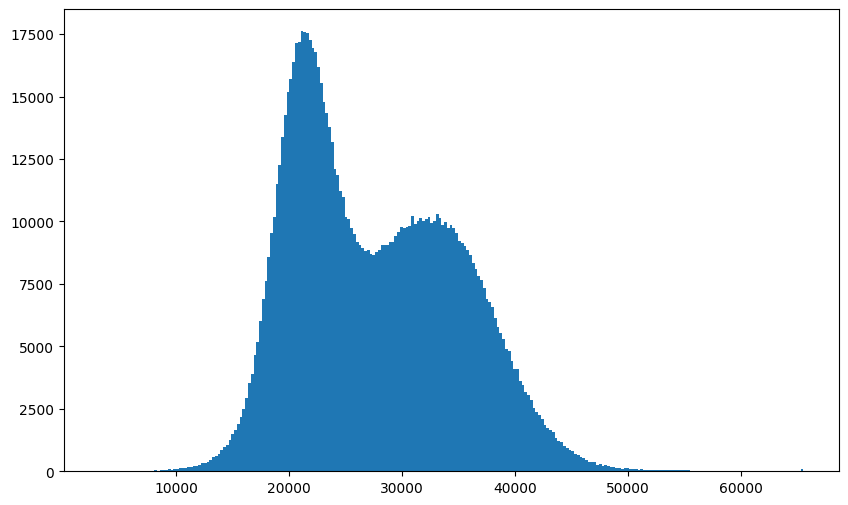

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = CFG.random_shift
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


In [7]:
class BCEWithDiceLoss(nn.Module):
    def __init__(self, weight_dice=0.5, smooth=1e-7):
        super(BCEWithDiceLoss, self).__init__()
        self.weight_dice = weight_dice
        self.smooth = smooth

    def forward(self, outputs, targets):
        bce_loss = nn.BCEWithLogitsLoss()(outputs, targets)
        
        intersection = torch.sum(torch.sigmoid(outputs) * targets)
        union = torch.sum(torch.sigmoid(outputs)) + torch.sum(targets)
        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1.0 - dice_score
        
        loss = self.weight_dice * dice_loss + (1 - self.weight_dice) * bce_loss
        return loss

### Training

In [8]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = BCEWithDiceLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.2724: 100%|██████████| 174/174 [03:38<00:00,  1.25s/it]
Val Loss: 1.2570: 100%|██████████| 49/49 [00:18<00:00,  2.58it/s]


FBeta : 0.3361	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 1.0104: 100%|██████████| 174/174 [03:29<00:00,  1.21s/it]
Val Loss: 1.1733: 100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


FBeta : 0.3254



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8667: 100%|██████████| 174/174 [03:20<00:00,  1.15s/it]
Val Loss: 0.9464: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


FBeta : 0.4656	SAVED MODEL



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8078: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 1.0359: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


FBeta : 0.4758	SAVED MODEL



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7673: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9179: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


FBeta : 0.4742



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7369: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 1.2255: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


FBeta : 0.3447



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7068: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9012: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


FBeta : 0.5014	SAVED MODEL



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6846: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9757: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


FBeta : 0.5169	SAVED MODEL



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6682: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 1.4715: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


FBeta : 0.2961



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6451: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9036: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


FBeta : 0.5006



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6213: 100%|██████████| 174/174 [03:03<00:00,  1.06s/it]
Val Loss: 0.9117: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


FBeta : 0.5447	SAVED MODEL



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6033: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.8978: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


FBeta : 0.5026



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5827: 100%|██████████| 174/174 [03:05<00:00,  1.06s/it]
Val Loss: 0.9362: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


FBeta : 0.5784	SAVED MODEL



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5741: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9893: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


FBeta : 0.5508



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5471: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.8539: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


FBeta : 0.6067	SAVED MODEL



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5263: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9748: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


FBeta : 0.4517



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5089: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9681: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


FBeta : 0.5796



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4959: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.8792: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


FBeta : 0.5853



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4787: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9361: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


FBeta : 0.5698



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4648: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9155: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


FBeta : 0.4907



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4406: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.8922: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


FBeta : 0.5870



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4357: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9120: 100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


FBeta : 0.5376



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4131: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9114: 100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


FBeta : 0.5718



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4074: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.8937: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


FBeta : 0.5919



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3988: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]
Val Loss: 0.9166: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


FBeta : 0.5822

fold: 1


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.3113: 100%|██████████| 177/177 [03:09<00:00,  1.07s/it]
Val Loss: 1.1947: 100%|██████████| 46/46 [00:15<00:00,  3.01it/s]


FBeta : 0.3850	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 1.0476: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9211: 100%|██████████| 46/46 [00:15<00:00,  3.01it/s]


FBeta : 0.4348	SAVED MODEL



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8935: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9131: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5065	SAVED MODEL



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8302: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.9282: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.3629



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7808: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8921: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.4339



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7578: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8677: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5383	SAVED MODEL



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7289: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8451: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5714	SAVED MODEL



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7105: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7980: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5261



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6863: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7904: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5404



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6598: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8316: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.5820	SAVED MODEL



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6445: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8074: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5780



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6214: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7918: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5404



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5998: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8339: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.5871	SAVED MODEL



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5799: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8021: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5650



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5667: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8323: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5861



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5479: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8097: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.5498



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5278: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7800: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.5813



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5150: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.7881: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5889	SAVED MODEL



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4977: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7954: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.5425



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4777: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7765: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5816



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4641: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8117: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6010	SAVED MODEL



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4440: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7862: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.5815



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4417: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8018: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5835



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4264: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7889: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.5741



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4226: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7878: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5869

fold: 2


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.3040: 100%|██████████| 177/177 [03:08<00:00,  1.06s/it]
Val Loss: 1.2156: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s]


FBeta : 0.4401	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 1.0090: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.4152: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.3467



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8705: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0488: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.4461	SAVED MODEL



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8043: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.1448: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.4261



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7548: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0230: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5638	SAVED MODEL



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7326: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9820: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.4961



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6981: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 1.1649: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.3924



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6844: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 1.2436: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.4236



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6658: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9141: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5585



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6419: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9407: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6119	SAVED MODEL



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6263: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0660: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.5857



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6072: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0340: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.5845



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5950: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9462: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6433	SAVED MODEL



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5772: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0149: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6422



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5660: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.9016: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5949



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5428: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.9541: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.5298



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5334: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9695: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6197



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5107: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9754: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6502	SAVED MODEL



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5013: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9375: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6562	SAVED MODEL



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4827: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9434: 100%|██████████| 46/46 [00:15<00:00,  3.01it/s]


FBeta : 0.6755	SAVED MODEL



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4778: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8858: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6557



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4606: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9913: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6587



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4441: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9217: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6794	SAVED MODEL



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4377: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9649: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6853	SAVED MODEL



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4299: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9324: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6867	SAVED MODEL

fold: 3


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.4137: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.2813: 100%|██████████| 46/46 [00:15<00:00,  3.01it/s]


FBeta : 0.4494	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 1.0825: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.1090: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.4118



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8884: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.1198: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.4795	SAVED MODEL



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8157: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.1936: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.3749



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7737: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 1.7024: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.2929



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7409: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.2462: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.4377



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7218: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0032: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.5149	SAVED MODEL



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6918: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.1095: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.5524	SAVED MODEL



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6746: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0500: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6260	SAVED MODEL



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6479: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9517: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6174



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6281: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9331: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6415	SAVED MODEL



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6069: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 1.0209: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6262



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5984: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8942: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6505	SAVED MODEL



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5781: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9284: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6278



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5617: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.9086: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6466



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5375: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9177: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6152



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5332: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8895: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6788	SAVED MODEL



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5127: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9276: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6332



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4975: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8972: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6908	SAVED MODEL



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4717: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9009: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6958	SAVED MODEL



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4630: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8780: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6656



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4510: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.8723: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6752



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4360: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9036: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6682



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4312: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.8829: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6673



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4250: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.9123: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6610

fold: 4


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.3734: 100%|██████████| 185/185 [03:19<00:00,  1.08s/it]
Val Loss: 1.3131: 100%|██████████| 38/38 [00:12<00:00,  2.97it/s]


FBeta : 0.3353	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 1.0442: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 1.0165: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.4514	SAVED MODEL



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8829: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 1.8580: 100%|██████████| 38/38 [00:12<00:00,  2.98it/s]


FBeta : 0.1936



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.8238: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 1.0952: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.3430



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7815: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8957: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.5091	SAVED MODEL



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7427: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.9307: 100%|██████████| 38/38 [00:12<00:00,  2.98it/s]


FBeta : 0.4560



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.7182: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 1.1288: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.3545



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6853: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.9249: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.4573



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6765: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8602: 100%|██████████| 38/38 [00:12<00:00,  2.97it/s]


FBeta : 0.5490	SAVED MODEL



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6510: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8826: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.5933	SAVED MODEL



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6381: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 1.1154: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.3493



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6156: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8421: 100%|██████████| 38/38 [00:12<00:00,  2.99it/s]


FBeta : 0.6196	SAVED MODEL



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6085: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8797: 100%|██████████| 38/38 [00:12<00:00,  2.99it/s]


FBeta : 0.6023



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5853: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.9003: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.4940



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5560: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8426: 100%|██████████| 38/38 [00:12<00:00,  2.99it/s]


FBeta : 0.5495



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5360: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.9066: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.4796



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5177: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8451: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.5634



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5061: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8799: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.5816



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4808: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8173: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.6578	SAVED MODEL



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4703: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8881: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


FBeta : 0.6449



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4584: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8346: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.6139



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4457: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8675: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]


FBeta : 0.6537



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4320: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8371: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.6487



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4264: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8392: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]


FBeta : 0.5999



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4201: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.8435: 100%|██████████| 38/38 [00:12<00:00,  2.99it/s]


FBeta : 0.6246

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6067
fbeta: 0.6010
fbeta: 0.6867
fbeta: 0.6958
fbeta: 0.6578


In [13]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6489


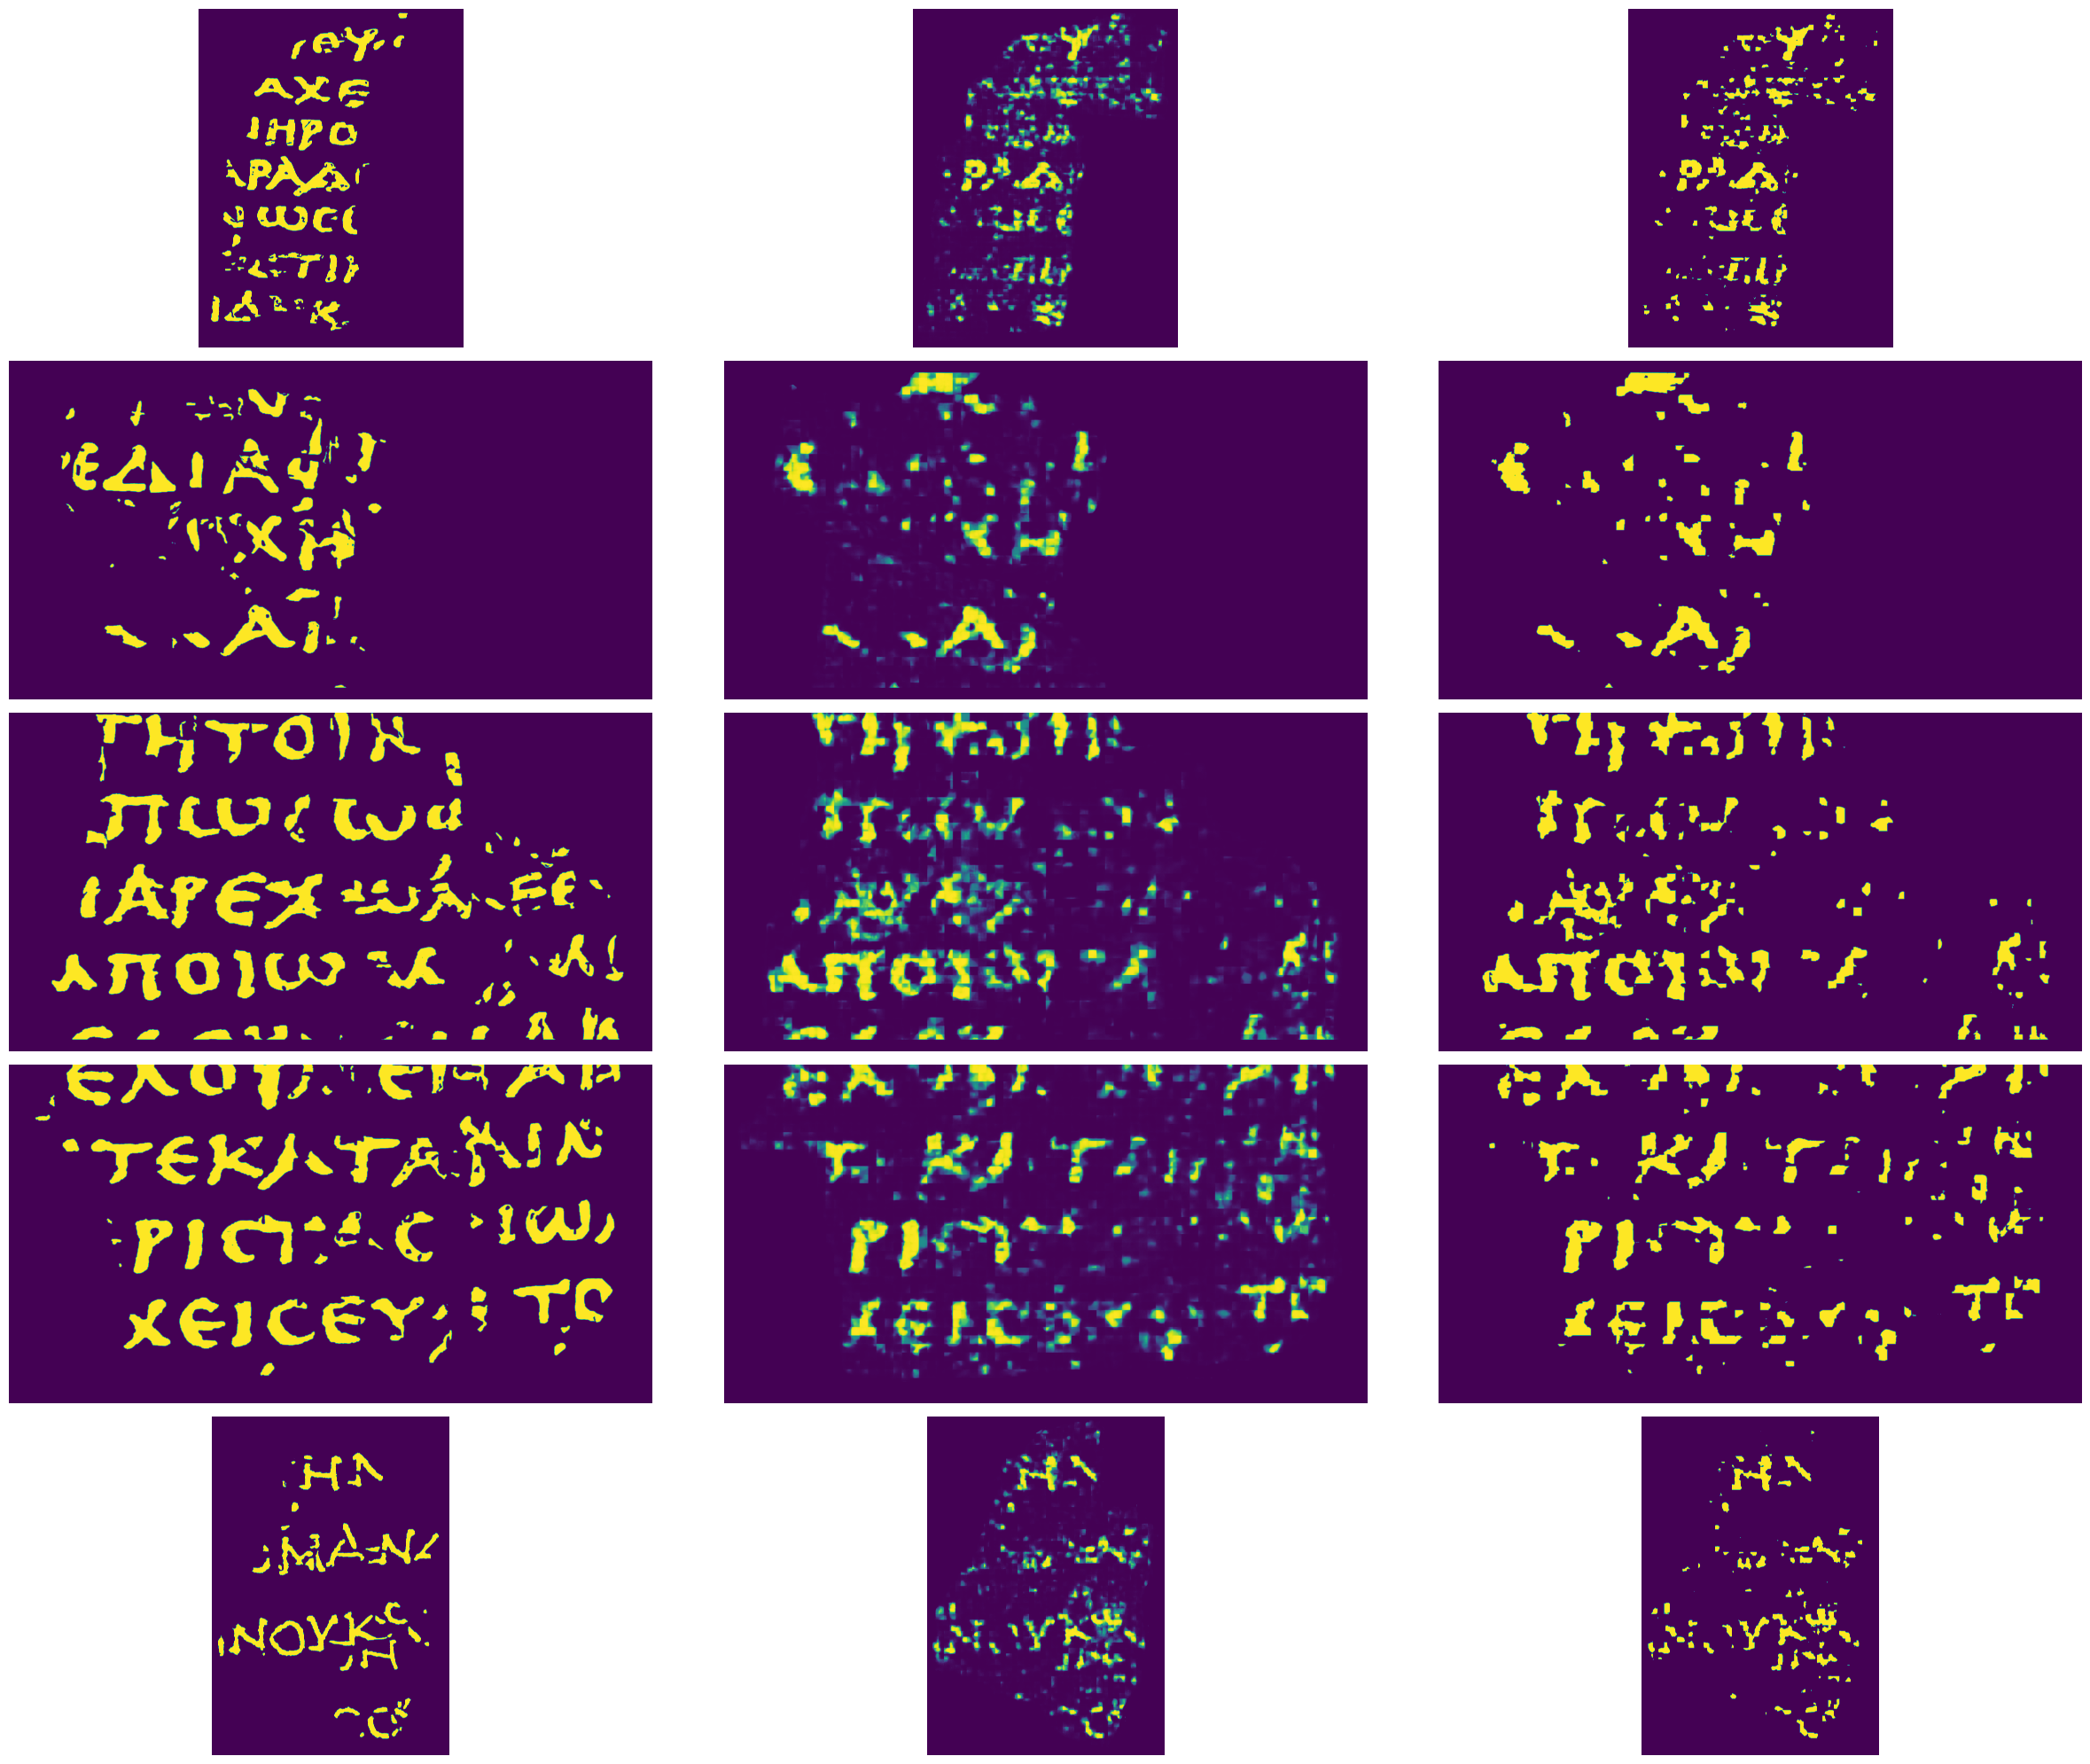

: 

In [14]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)